---
title: 2D Non-Linear Convection
short_title: Linear Convection
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

* Jax-ify
* Don't Reinvent the Wheel

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".home"])

# append to path
sys.path.append(str(root))

Let's start with a simple 2D Linear Advection scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} &= 0 \\
\frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} &= 0 
\end{aligned}
$$ (eq:2dnadvection)

For the PDE {eq}`eq:pde`, we are going to do a forward difference discretization in space and a backwards in time. It is given by:

$$
\begin{aligned}
u_{i,j}^{n+1} &= 
u_{i,j}^{n} - 
u \frac{\Delta t}{\Delta x}\left( u_{i,j}-u_{i-1,j}^n \right)
- v \frac{\Delta t}{\Delta y}\left( u_{i,j-1}-u_{i,j}^n \right) \\
v_{i,j}^{n+1} &= 
v_{i,j}^{n} - 
u \frac{\Delta t}{\Delta x}\left( v_{i,j}-v_{i-1,j}^n \right)
- v \frac{\Delta t}{\Delta y}\left( v_{i,j-1}-v_{i,j}^n \right) 
\end{aligned}
$$ (eq:advection_discretize)

Citation [cite](dot:10.1175/JTECH-D-20-0104.1).

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import serket as sk
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Array, Float
import wandb
import diffrax
import kernex as kx
import serket as sk

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", False)


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
# defime some variables
# nx, ny = 51, 51
# nt = 100
# c = 1.0
# dx, dy = 2/(nx-1), 2/(ny-1)

# sigma = 0.2
# dt = sigma * dx

nx, ny = 101, 101
nt = 80
c = 1.0
dx, dy = 2/(nx-1), 2/(ny-1)

sigma = .2
dt = sigma * dx
t0 = 0
tmax = 0.5
ts = np.arange(t0, tmax, step=dt)

x_grid = np.linspace(0, 2, nx)
y_grid = np.linspace(0, 2, ny)

In [4]:
def init_hat(nx, ny, dx, dy):
    u = np.ones((nx,ny))
    
    u[int(.5 / dx):int(1 / dx + 1),
          int(.5 / dy):int(1 / dy + 1)] = 2
    
    return u

In [5]:
def fin_bump(x):
    if x <= 0 or x >= 1:
        return 0
    else:
        return 100*np.exp(-1./(x-np.power(x,2.)))

def init_smooth(nx, ny, dx, dy):
    
    u = np.ones((nx, ny))
    
    for ix in range(nx):
        for iy in range(ny):
            x = ix * dx
            y = iy * dy
            u[ix, iy] = fin_bump(x/1.5) * fin_bump(y/1.5) + 1.
                     
    return u

In [6]:
# initialize field to be zero
# u_init = init_hat(nx, ny, dx, dy)
u_init = init_hat(nx, ny, dx, dy)
v_init = init_hat(nx, ny, dx, dy)
u = u_init.copy()
v = v_init.copy()

In [7]:
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing="ij")

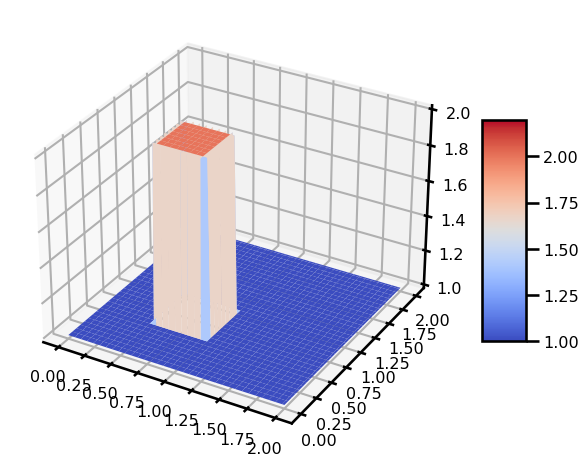

In [8]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X_grid, Y_grid, u, 
                       cmap=cm.coolwarm,
                       vmin=u.min(), vmax=u.max()+0.1*u.max())
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()


Steps:

1. Calculate the RHS
2. Apply the Boundary Conditions


In [9]:
# initialize field to be zero
# u_init = init_hat(nx, ny, dx, dy)
u_init = init_hat(nx, ny, dx, dy)
v_init = init_hat(nx, ny, dx, dy)
u = u_init.copy()
v = v_init.copy()

for t in tqdm(ts): ##loop across number of time steps
    
    un = u.copy()
    vn = v.copy()
    # print("u:", un.min(), un.max())
    # print("v:", vn.min(), vn.max())
    # print("du_dx:", (un[1:, 1:] - un[1:, :-1]).min()/dy, (un[1:, 1:] - un[1:, :-1]).max()/dy)
    # print("du_dy:", (un[1:, 1:] - un[:-1, 1:]).min()/dx, (un[1:, 1:] - un[:-1, 1:]).max()/dx)
    # print("du_dx:", (un[1:, 1:] - un[1:, :-1]).min()/dy, (un[1:, 1:] - un[1:, :-1]).max()/dy)
    u[1:, 1:] = (un[1:, 1:] - 
                 (un[1:, 1:] * c * dt / dy * (un[1:, 1:] - un[1:, :-1])) -
                  vn[1:, 1:] * c * dt / dx * (un[1:, 1:] - un[:-1, 1:]))
    v[1:, 1:] = (vn[1:, 1:] -
                 (un[1:, 1:] * c * dt / dy * (vn[1:, 1:] - vn[1:, :-1])) -
                 vn[1:, 1:] * c * dt / dx * (vn[1:, 1:] - vn[:-1, 1:]))
    
    
#     print("u:", u.min(), u.max())
#     print("v:", v.min(), v.max())
    
    u[0, :] = 1
    u[-1, :] = 1
    u[:, 0] = 1
    u[:, -1] = 1
    
    v[0, :] = 1
    v[-1, :] = 1
    v[:, 0] = 1
    v[:, -1] = 1


  0%|          | 0/125 [00:00<?, ?it/s]

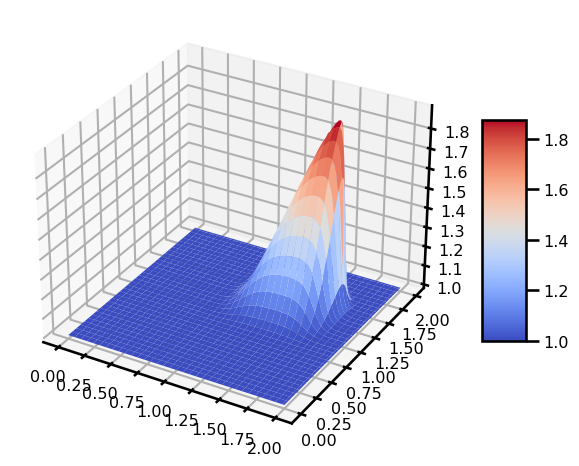

In [10]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    X_grid, Y_grid, u, 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()

## New API

### Domain

In [11]:
from jaxsw._src.domain import Domain, TimeDomain
from jaxsw._src.fields.base import Field
from jaxsw._src.operators.fd import Difference
from jaxsw._src.operators.custom import FuncOperator

In [12]:
xmin, ymin = 0., 0.
xmax, ymax = 2.0, 2.0
nx, ny = 101, 101
nt = 100
c = 1.0
sigma = 0.2
dt = sigma * dx

# initialize spatial domain
domain = Domain.from_numpoints(xmin=(xmin,ymin), xmax=(xmax,ymax), N=(nx, ny))




In [13]:
domain.size, domain.dx

((101, 101), (0.02, 0.02))

### Initial Condition

In [14]:
def init_hat(nx, ny, dx, dy):
    u = np.ones((nx,ny))
    
    u[int(.5 / dx):int(1 / dx + 1),
          int(.5 / dy):int(1 / dy + 1)] = 2.0
    
    return u

def fin_bump(x):
    if x <= 0 or x >= 1:
        return 0
    else:
        return 100*np.exp(-1./(x-np.power(x,2.)))

def init_smooth(nx, ny, dx, dy):
    
    u = np.ones((nx, ny))
    
    for ix in range(nx):
        for iy in range(ny):
            x = ix * dx
            y = iy * dy
            u[ix, iy] = fin_bump(x/1.5) * fin_bump(y/1.5) + 1.
                     
    return u

In [15]:

# initialize field to be zero
def init_u_hat(domain):
    dx, dy = domain.dx
    
    u_init = jnp.ones(domain.size)
    u_init = u_init.at[
        int(.5 / dx):int(1 / dx + 1),
        int(.5 / dy):int(1 / dy + 1)
    ].set(2.0)
    
    return Field(u_init, domain)

def init_u_smooth(domain):
    dx, dy = domain.dx
    nx, ny = domain.size
    
    u_init = init_smooth(nx, ny, dx, dy)
    
    return Field(jnp.asarray(u_init), domain)

In [16]:
# u = init_u_smooth(domain)
u = init_u_hat(domain)
v = init_u_hat(domain)

2023-03-14 19:29:32.126937: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


### Boundary Conditions

In [17]:
def f(u: Field) -> Field:
    
    u = u.at[0,:].set(1.0)
    u = u.at[-1,:].set(1.0)
    u = u.at[:,0].set(1.0)
    u = u.at[:,-1].set(1.0)
    return u


In [18]:
from jaxsw._src.operators.custom import FuncOperator

In [19]:
bc_fn = FuncOperator(f=f)

In [20]:

# initialize difference
df_dx = Difference(u.domain, axis=0, accuracy=1, method="backward")
df_dy = Difference(u.domain, axis=1, accuracy=1, method="backward")

In [21]:
from typing import Optional
class DynamicalSystem(eqx.Module):
    solver: diffrax.AbstractSolver
    saveat: Optional[diffrax.SaveAt] = None
    controller: Optional[diffrax.PIDController]=None
    t_domain: TimeDomain
    
    def __init__(self, solver, t_domain, saveat=None, controller=None):
        self.solver = solver
        self.t_domain = t_domain
        self.saveat = saveat
        self.controller = controller
    
    @staticmethod
    def equation_of_motion(t: float, u: Field, args):
        # parse inputs
        u, v = u
        
        # apply boundary conditions
        u = bc_fn(u)
        v = bc_fn(v)
        
        # FD - u vector
        du_dx = df_dx(u)
        du_dy = df_dy(u)

        unew = u * du_dx + v * du_dy

        # FD - v vector
        dv_dx = df_dx(v)
        dv_dy = df_dy(v)
        
        vnew = u * dv_dx + v * dv_dy
        
        # RHS
        unew = eqx.tree_at(lambda x: x.values, unew, - unew.values)
        vnew = eqx.tree_at(lambda x: x.values, vnew, - vnew.values)
        
        return unew,vnew
    
    def integrate(self, u: Field, dt: float) -> Field:
        
        # solver = diffrax.ImplicitEuler()
        sol = diffrax.diffeqsolve(
            terms=diffrax.ODETerm(self.equation_of_motion),
            solver=self.solver,
            t0=self.t_domain.tmin,
            t1=self.t_domain.tmax,
            dt0=dt,
            y0=u,
            saveat=self.saveat,
            max_steps=None,
        )
        return sol.ys

In [22]:
#SPATIAL DISCRETIZATION
u = init_u_hat(domain)
v = init_u_hat(domain)

u_init = (u, v)
print(u_init[0].min(), u_init[0].max(), u_init[1].min(), u_init[1].max())
out = DynamicalSystem.equation_of_motion(0, u_init, 0)
out[0].min(), out[0].max(), out[1].min(), out[1].max()

1.0 2.0 1.0 2.0


2023-03-14 19:29:32.372848: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:461] fastpath_data is none


(Array(-200., dtype=float32),
 Array(50., dtype=float32),
 Array(-200., dtype=float32),
 Array(50., dtype=float32))

In [23]:
#SPATIAL DISCRETIZATION
u = init_u_hat(domain)
v = init_u_hat(domain)
# u = init_u_smooth(domain)
# v = init_u_smooth(domain)

u_init = (u, v)

# TEMPORAL DISCRETIZATION
t0 = 0.0
tmax = 0.5

# CFL condition
def cfl_cond(dx, c, sigma):
    assert sigma <= 1.0
    return (sigma * dx) / c

# temporal parameters
c = 1.0
sigma = 0.2
dt = cfl_cond(dx=dx, c=c, sigma=sigma)
# dt = 0.0001
# dt = sigma * dx



# TEMPORAL DISCRETIZATION
# initialize temporal domain
t_domain = TimeDomain(tmin=0.0, tmax=0.5, dt=dt)
ts = jnp.linspace(t0, tmax, 50)
saveat = diffrax.SaveAt(ts=ts)

# # STEPSIZE CONTROLLER
# rtol = 1e-5
# atol = 1e-5
# pcoeff = 0.3
# icoeff = 0.4
# dtmax = 0.001
# stepsize_controller = diffrax.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dtmax
# )
stepsize_controller = None
# TIME STEPPER
solver = diffrax.Euler()
# solver = diffrax.Tsit5()
# DYNAMICAL SYSTEM

dyn_model = DynamicalSystem(solver, t_domain, saveat, controller=stepsize_controller)

# integration
u_sol = dyn_model.integrate(u_init, dt)
u_sol, v_sol  = u_sol

In [24]:
u.domain.grid.shape

(101, 101, 2)

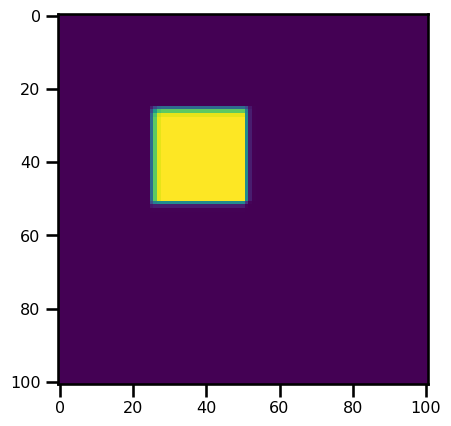

In [25]:
plt.imshow(u_sol.values[1])

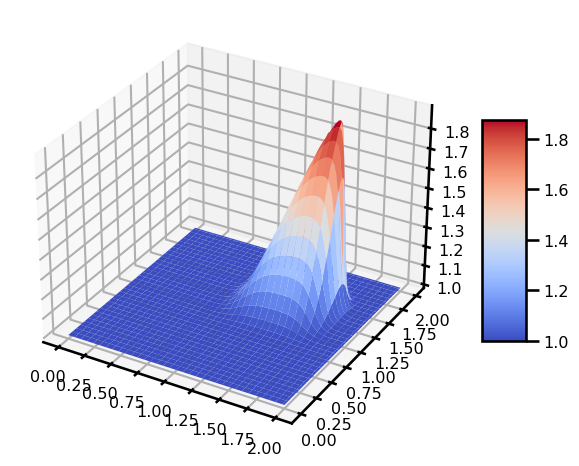

In [26]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(
    u.domain.grid[..., 0], 
    u.domain.grid[..., 1],
    u_sol.values[-1], 
    cmap=cm.coolwarm)
plt.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()